In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the list_ingredients.txt file

ingredient_list_path = '/content/drive/My Drive/APS360/test_pipeline/list_ingredients.txt'
# Path to the list_ingredients.txt file
#ingredient_list_path = r'C:\Users\arthu\APS360\Project_New\ML_code\list_ingredients.txt'
# Initialize ingredient lists
ingredients = []
ingredient_frequencies = []

# Read the file and parse ingredients with frequencies
with open(ingredient_list_path, 'r') as f:
    for line in f:
        # Stop reading if we encounter the 'Top 10 Most Common Ingredients' line
        if line.startswith('Top'):
            break

        # Skip lines that are not ingredients or are headers
        if ':' in line or line.strip() == '':
            continue

        # Extract the ingredient name and its frequency
        ingredient = line.split('(')[0].strip()  # Extract ingredient name
        frequency = int(line.split('(')[1].replace(')', '').strip())  # Extract frequency
        ingredients.append(ingredient)
        ingredient_frequencies.append(frequency)

# Check how many ingredients were read and print a few for verification
print(f"Total ingredients: {len(ingredients)}")
print(f"First 10 ingredients: {ingredients[:10]}")  # Display the first 10 ingredients for verification
print(f"First 10 frequencies: {ingredient_frequencies[:10]}")  # Display the first 10 frequencies for verification

# Create a dictionary mapping each ingredient to a unique index (for one-hot encoding)
ingredient_dict = {ingredient: i for i, ingredient in enumerate(ingredients)}

# Create a dictionary mapping each ingredient to its frequency
ingredient_freq_dict = {ingredient: freq for ingredient, freq in zip(ingredients, ingredient_frequencies)}

# Print some examples for verification
print(f"Total unique ingredients mapped: {len(ingredient_dict)}")
print("Example ingredient mapping (index):", list(ingredient_dict.items())[:10])
print("Example ingredient mapping (frequency):", list(ingredient_freq_dict.items())[:10])



Total ingredients: 53
First 10 ingredients: ['agent1', 'agent2', 'allium', 'berries', 'butter1', 'butter2', 'butter3', 'butter4', 'cheese', 'chocolate']
First 10 frequencies: [4337, 4337, 5320, 4501, 3601, 3601, 3601, 3600, 5127, 4310]
Total unique ingredients mapped: 53
Example ingredient mapping (index): [('agent1', 0), ('agent2', 1), ('allium', 2), ('berries', 3), ('butter1', 4), ('butter2', 5), ('butter3', 6), ('butter4', 7), ('cheese', 8), ('chocolate', 9)]
Example ingredient mapping (frequency): [('agent1', 4337), ('agent2', 4337), ('allium', 5320), ('berries', 4501), ('butter1', 3601), ('butter2', 3601), ('butter3', 3601), ('butter4', 3600), ('cheese', 5127), ('chocolate', 4310)]


In [ ]:
import os
import random
import torch
import glob
from torch.utils.data import Dataset
from PIL import Image

class IngredientDataset(Dataset):
    def __init__(self, image_folder, label_folder, ingredient_dict, transform=None, folder_percentage=1.0, image_percentage=1.0):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform
        self.ingredient_dict = {k.strip().lower(): v for k, v in ingredient_dict.items()}  # Normalize keys
        self.data = []

        # Collect all key names (subfolders in image_folder)
        all_folders = [key_name for key_name in os.listdir(label_folder) if key_name.endswith('.txt')]

        # Sample a subset of folders based on the folder_percentage
        folder_count = int(len(all_folders) * folder_percentage)
        random.seed(42)
        selected_folders = random.sample(all_folders, folder_count)

        for key_name in selected_folders:
            key_name_no_ext = key_name.replace('.txt', '')
            image_dir = os.path.join(image_folder, key_name_no_ext)
            label_file = os.path.join(label_folder, key_name)

            # Check if the image folder and label file both exist
            if not os.path.exists(image_dir):
                print(f"Missing image folder for key: {key_name_no_ext}")
                continue

            if not os.path.exists(label_file):
                print(f"Missing label file for key: {key_name_no_ext}")
                continue

            # Collect all images in the folder
            images = glob.glob(os.path.join(image_dir, "*.jpg"))

            # Debug: Check image count in folder
            print(f"Key: {key_name_no_ext}, Total Images: {len(images)}")

            # Sample a subset of images within the folder based on image_percentage
            image_count = int(len(images) * image_percentage)
            selected_images = random.sample(images, image_count) if image_count < len(images) else images

            # Add each image as a separate entry in the dataset
            for img_path in selected_images:
                self.data.append((key_name_no_ext, img_path, label_file))

        # Debug: Final dataset size
        print(f"Total Dataset Size: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        key_name, img_path, label_path = self.data[idx]

        # Load and transform the image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Load and encode the label
        with open(label_path, 'r') as f:
            ingredients = f.read().strip().split('\n')

        # Debug: Check label file contents
        #print(f"Label File ({label_path}) Contents: {ingredients}")

        label_tensor = torch.tensor(self._encode_ingredients(ingredients), dtype=torch.float)

        # Debug: Check label tensor
        #print(f"Encoded Label Tensor for {key_name}: {label_tensor.nonzero(as_tuple=True)}")

        return key_name, image, label_tensor

    def _encode_ingredients(self, ingredients):
        """Convert list of ingredients to a one-hot vector."""
        ingredient_vector = [0] * len(self.ingredient_dict)
        for ingredient in ingredients:
            normalized_ingredient = ingredient.strip().lower()
            if normalized_ingredient in self.ingredient_dict:
                ingredient_vector[self.ingredient_dict[normalized_ingredient]] = 1
            else:
                # Debug: Log unmapped ingredient
                print(f"Unmapped Ingredient: {ingredient}")
        return ingredient_vector


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Define image transformations (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset paths "C:\Users\arthu\APS360\Project_New\balanced_small_dataset\images\train\05123e5f1b"
#"F:\full_dataset\images"
#r'/Users/arthurzhuang/Desktop/APS360/APS360_test_pipeline/list_ingredients.txt'

train_image_folder = '/content/drive/My Drive/APS360/test_pipeline/test_pipeline/images/train'
train_label_folder = '/content/drive/My Drive/APS360/test_pipeline/test_pipeline/labels/train'
val_image_folder = '/content/drive/My Drive/APS360/test_pipeline/test_pipeline/images/val'
val_label_folder = '/content/drive/My Drive/APS360/test_pipeline/test_pipeline/labels/val'
test_image_folder = r'/content/drive/My Drive/APS360/test_pipeline/test_pipeline/images/test'
test_label_folder = r'/content/drive/My Drive/APS360/test_pipeline/test_pipeline/labels/test'



# Initialize datasets and DataLoaders
train_dataset = IngredientDataset(
    train_image_folder, train_label_folder, ingredient_dict, transform=transform, folder_percentage=1.0, image_percentage=1.0
)
val_dataset = IngredientDataset(
    val_image_folder, val_label_folder, ingredient_dict, transform=transform, folder_percentage=1.0, image_percentage=1
)
test_dataset = IngredientDataset(
    test_image_folder, test_label_folder, ingredient_dict, transform=transform, folder_percentage=1.0, image_percentage=1.0
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verify DataLoader
print("Verifying Train Loader...")
for batch_idx, (key_name, image, label) in enumerate(val_loader):
    print(f"Batch {batch_idx + 1}")
    print(f"Key Name: {key_name}")
    print(f"Image Tensor Shape: {image.shape}")
    print(f"Label Tensor Shape: {label.shape}")
    print(f"Non-zero Labels: {label.nonzero(as_tuple=True)}")  # Check for non-zero labels
    break  # Break after the first batch for verification


Key: a9fdaa2c20, Total Images: 1
Total Dataset Size: 1
Key: a9fdaa2c20, Total Images: 1
Total Dataset Size: 1
Key: a9fdaa2c20, Total Images: 1
Total Dataset Size: 1
Verifying Train Loader...
Batch 1
Key Name: ('a9fdaa2c20',)
Image Tensor Shape: torch.Size([1, 3, 224, 224])
Label Tensor Shape: torch.Size([1, 53])
Non-zero Labels: (tensor([0, 0, 0, 0, 0, 0, 0]), tensor([11, 24, 34, 37, 39, 40, 42]))


In [ ]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:

import torch
import torch.nn as nn
from torchvision.models import vit_b_16

class VITIngredientDetector(nn.Module):
   def __init__(self, output_size=100):
       super().__init__()
       # Load pretrained ViT
       self.vit = vit_b_16(pretrained=True)

       # Replace classifier head with more sophisticated head
       self.head = nn.Sequential(
           nn.Linear(768, 1024),
           nn.LayerNorm(1024),
           nn.ReLU(),
           nn.Dropout(0.3),
           nn.Linear(1024, 512),
           nn.LayerNorm(512),
           nn.ReLU(),
           nn.Dropout(0.2),
           nn.Linear(512, output_size)
       )
       self.vit.heads = self.head

       # Initially freeze all parameters
       for param in self.vit.parameters():
           param.requires_grad = False

       # Unfreeze head parameters
       for param in self.head.parameters():
           param.requires_grad = True

       # Unfreeze last two transformer layers for fine-tuning
       for param in self.vit.encoder.layers[-2:].parameters():
           param.requires_grad = True

   def unfreeze_last_n_layers(self, n):
       """Unfreeze the last n transformer layers"""
       for param in self.vit.encoder.layers[-n:].parameters():
           param.requires_grad = True

   def forward(self, x):
       return self.vit(x)

In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

def compute_accuracy(y_true, y_pred):
    """
    Compute accuracy as ratio of correctly predicted positive labels to total positive labels
    y_true: ground truth labels
    y_pred: predicted labels
    """
    total_samples = y_true.shape[0]
    accuracies = []

    for i in range(total_samples):
        true_positives = np.sum(np.logical_and(y_true[i] == 1, y_pred[i] == 1))
        total_positives = np.sum(y_true[i] == 1)
        if total_positives > 0:  # Avoid division by zero
            accuracies.append(true_positives / total_positives)

    return np.mean(accuracies) if accuracies else 0.0


def save_predictions(epoch, labels, predictions, key_names, save_dir="/content/drive/My Drive/APS360/test_pipeline/results.txt", samples_per_epoch=484):
    """
    Save validation predictions and labels to a single text file
    """
    try:
        os.makedirs(os.path.dirname(save_dir), exist_ok=True)

        with open(save_dir, 'w') as f:  # Write mode to overwrite previous contents
            for i in range(min(samples_per_epoch, len(labels))):
                try:
                    current_key = str(key_names[i]).replace('/', '_').replace('\\', '_')

                    # Get predicted labels
                    pred_indices = np.where(predictions[i] == 1)[0]
                    predictions_list = [list(ingredient_dict.keys())[idx] for idx in pred_indices]

                    # Store cleaned predictions to check for duplicates
                    seen_base_ingredients = set()
                    unique_predictions = []

                    for pred in predictions_list:
                        # Remove trailing numbers from ingredient name
                        base_ingredient = ''.join(c for c in pred.rstrip('0123456789')).strip()

                        # Only add if we haven't seen this base ingredient before
                        if base_ingredient not in seen_base_ingredients:
                            seen_base_ingredients.add(base_ingredient)
                            unique_predictions.append(base_ingredient)  # Add cleaned version

                    # Write unique predictions
                    for pred in unique_predictions:
                        f.write(f"{pred}\n")

                except IndexError as e:
                    print(f"Error processing sample {i}: {e}")
                    continue
                except Exception as e:
                    print(f"Unexpected error processing sample {i}: {e}")
                    continue

        print(f"Successfully saved predictions to {save_dir}")

    except Exception as e:
        print(f"Error saving predictions: {e}")
        print(f"Attempted to save to: {save_dir}")
        print(f"Current working directory: {os.getcwd()}")



def custom_multilabel_metrics(y_true, y_pred, class_names):
    """
    Custom metric calculation that consolidates predictions for all label groups
    (e.g., flour1-4, agent1-2, etc.) based on ground truth
    """
    #print("Entering custom_multilabel_metrics")
    # Create copies to avoid modifying originals
    y_true_modified = y_true.copy()
    y_pred_modified = y_pred.copy()

    # Create a dictionary to group indices by base label
    base_label_groups = {}
    for i, name in enumerate(class_names):
        # Extract base label by removing trailing numbers
        base_label = ''.join(char for char in name if not char.isdigit())
        if base_label not in base_label_groups:
            base_label_groups[base_label] = []
        base_label_groups[base_label].append(i)
    #print(base_label_groups)

    # For each sample
    for i in range(len(y_true)):
        # Handle each base label group
        for base_indices in base_label_groups.values():
            # Only process groups with multiple variants (len > 1)
            if len(base_indices) > 1:
                # Check if any variant exists in ground truth
                true_variant_indices = [idx for idx in base_indices if y_true[i, idx] == 1]
                if true_variant_indices:
                    true_variant_idx = true_variant_indices[0]  # Get the ground truth variant index
                    # If any variant was predicted, consolidate to the correct one
                    if any(y_pred[i, idx] == 1 for idx in base_indices):
                        # Zero out all variant predictions
                        for idx in base_indices:
                            y_pred_modified[i, idx] = 0
                        # Set the correct variant to 1
                        y_pred_modified[i, true_variant_idx] = 1

    # Calculate metrics using modified predictions
    precision = precision_score(y_true_modified, y_pred_modified, average="samples", zero_division=0)
    recall = recall_score(y_true_modified, y_pred_modified, average="samples", zero_division=0)
    f1 = f1_score(y_true_modified, y_pred_modified, average="samples", zero_division=0)
    #accuracy = compute_accuracy(y_true_modified, y_pred_modified)

    # Generate classification report

    return precision, recall, f1



In [ ]:
from torchvision.models import vit_b_16
import torch

# Load the model
model_path = "/content/drive/My Drive/APS360/test_pipeline/best_model_checkpoint_epoch_6.pth"  # Update with the correct path
output_size = len(ingredient_dict)  # The size of the output matches the number of ingredients

checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

# Check the keys in the checkpoint
print("Keys in checkpoint:", checkpoint.keys())

<ipython-input-60-c88b9cff1ecd>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device('cpu'))


Keys in checkpoint: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'f1_score', 'precision', 'recall', 'train_loss', 'val_loss'])


In [ ]:
import torch

# Load the checkpoint
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

# Initialize the model with the correct output size
output_size = len(ingredient_dict)  # Number of classes
model = VITIngredientDetector(output_size=output_size)

# Load only the model weights
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()  # Set the model to evaluation mode

print("Model loaded successfully from checkpoint.")

<ipython-input-61-494c912426c4>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
/usr/local/lib/python3

Model loaded successfully from checkpoint.


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

def test_model(model, test_loader, device, class_names=list(ingredient_dict.keys()), save_dir="test_results"):
    """
    Test the model on the test set, compute metrics, save predictions, and save per-sample F1 scores to a text file.
    """
    # Move model to device
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Initialize variables for metrics and tracking
    test_losses = []  # Track per-batch loss
    all_true_labels = []
    all_pred_labels = []
    all_key_names = []
    all_f1_scores = []  # Store per-sample F1 scores from custom metric

    # Criterion (optional for loss calculation during testing)
    criterion = torch.nn.BCEWithLogitsLoss()

    print("Testing the model...")
    with torch.no_grad():
        with tqdm(total=len(test_loader), desc="Testing", unit="batch") as pbar:
            for batch_idx, (key_name, images, labels) in enumerate(test_loader):
                # Move data to device
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Compute loss (optional, for logging purposes)
                loss = criterion(outputs, labels)
                test_losses.append(loss.item())  # Track loss for plotting

                # Convert logits to probabilities and binary predictions
                probabilities = torch.sigmoid(outputs)
                predictions = (probabilities > 0.35).int()

                # Track ground truth, predictions, and key names
                all_true_labels.append(labels.cpu().numpy())
                all_pred_labels.append(predictions.cpu().numpy())
                all_key_names.extend(key_name)

                # Compute and store per-sample F1 scores using custom metric
                for i in range(len(labels)):
                    true = labels[i].cpu().numpy()
                    pred = predictions[i].cpu().numpy()
                    _, _, per_image_f1 = custom_multilabel_metrics(true[np.newaxis, :], pred[np.newaxis, :], class_names)
                    all_f1_scores.append((key_name[i], per_image_f1))  # Store key and F1 score as a tuple

                # Update progress bar
                pbar.set_postfix({"Loss": f"{loss.item():.4f}"})
                pbar.update(1)

    # Combine results across all batches
    all_true_labels = np.vstack(all_true_labels)
    all_pred_labels = np.vstack(all_pred_labels)

    # Calculate overall metrics using custom and scikit-learn functions
    precision, recall, f1 = custom_multilabel_metrics(all_true_labels, all_pred_labels, class_names)
    accuracy = compute_accuracy(all_true_labels, all_pred_labels)

    # Print metrics
    print("\nTest Metrics (Custom):")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy (Custom): {accuracy:.4f}")
    plot_test_metrics(test_losses=test_losses, precision=precision, recall=recall, f1=f1)

    # Generate and print scikit-learn classification report
    print("\nClassification Report (Scikit-Learn):")
    print(classification_report(all_true_labels, all_pred_labels, target_names=class_names, zero_division=0))

    # Save predictions for analysis
    #save_predictions(epoch=0, labels=all_true_labels, predictions=all_pred_labels, key_names=all_key_names)


def plot_test_metrics(test_losses, precision, recall, f1):
    """Plot the test loss and metrics."""
    # Plot test loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", marker='o')
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Test Loss")
    plt.legend()

    # Plot metrics
    metrics = [precision, recall, f1]
    metric_labels = ["Precision", "Recall", "F1 Score"]
    plt.subplot(1, 2, 2)
    plt.bar(metric_labels, metrics, color=['skyblue', 'lightgreen', 'salmon'])
    plt.ylim(0, 1)
    plt.title("Test Metrics")
    plt.ylabel("Score")

    plt.tight_layout()
    plt.show()


Testing the model...


Testing: 100%|██████████| 1/1 [00:01<00:00,  1.08s/batch, Loss=0.4468]



Test Metrics (Custom):
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy (Custom): 0.0000


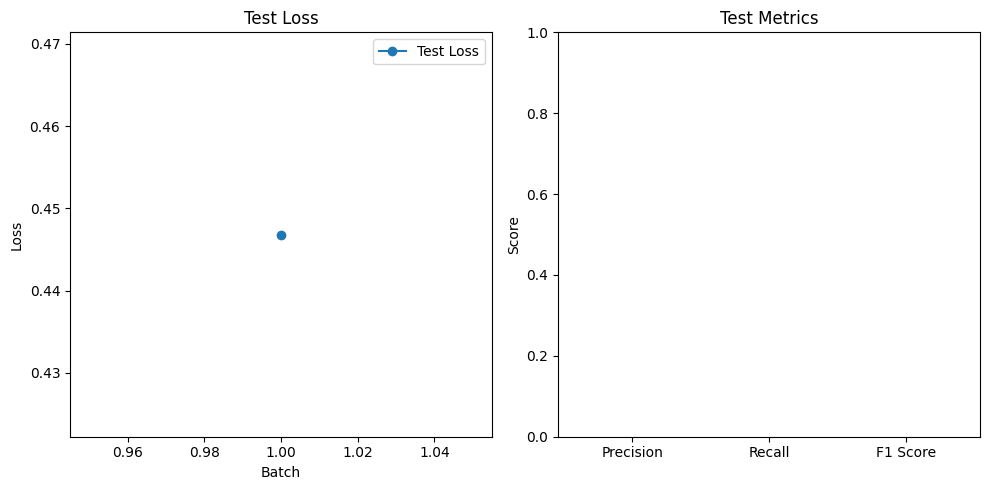


Classification Report (Scikit-Learn):
                                   precision    recall  f1-score   support

                           agent1       0.00      0.00      0.00         0
                           agent2       0.00      0.00      0.00         0
                           allium       0.00      0.00      0.00         0
                          berries       0.00      0.00      0.00         0
                          butter1       0.00      0.00      0.00         0
                          butter2       0.00      0.00      0.00         0
                          butter3       0.00      0.00      0.00         0
                          butter4       0.00      0.00      0.00         0
                           cheese       0.00      0.00      0.00         0
                        chocolate       0.00      0.00      0.00         0
                         cinnamon       0.00      0.00      0.00         0
                        condiment       0.00      0.00      

In [ ]:
test_model(
    model=model,
    test_loader=test_loader,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

In [ ]:
!pip install websockets flask flask-socketio pyngrok

In [ ]:
import time
time.sleep(5)

In [ ]:
!ngrok authtoken 2pRcrhNdihhdnIZreXEcTcOkTPl_6CpJxpqeoNi77SakaKfpv

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import http.server
import socketserver
import os
from pyngrok import ngrok

# Kill any existing ngrok processes
ngrok.kill()

# Your folder path
FOLDER_PATH = "/content/drive/My Drive/APS360/test_pipeline/"

# Change to the directory containing your files
os.chdir(FOLDER_PATH)

# Create a basic HTML file
html_content = """
<!DOCTYPE html>
<html>
<head>
    <title>Images</title>
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 20px;
        }
        .image-container {
            display: flex;
            flex-wrap: wrap;
            gap: 20px;
        }
        img {
            max-width: 300px;
            height: auto;
            border: 1px solid #ddd;
            border-radius: 4px;
            padding: 5px;
        }
        h1, h2 {
            color: #333;
        }
        pre {
            background-color: #f5f5f5;
            padding: 15px;
            border-radius: 4px;
            overflow-x: auto;
        }
    </style>
</head>
<body>
    <h1>FOOD IMAGES:</h1>
    <div class="image-container">
"""

# Add images to HTML
for file in os.listdir(FOLDER_PATH):
    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
        html_content += f'<img src="{file}" alt="{file}">\n'

# Add text content
try:
    with open("results.txt", 'r') as f:
        text_content = f.read()
except:
    text_content = "No results found"

html_content += f"""
    </div>
    <h2>INGREDIENT PREDICTIONS:</h2>
    <pre>{text_content}</pre>
</body>
</html>
"""

# Write the HTML file
with open("index.html", 'w') as f:
    f.write(html_content)

# Set up a basic handler
handler = http.server.SimpleHTTPRequestHandler

# Start the server on port 8000
with socketserver.TCPServer(("", 8000), handler) as httpd:
    # Connect using your existing endpoint
    public_url = ngrok.connect(8000, subdomain="094c46ba6af86304")
    print(f"\n{'='*50}")
    print(f"Server running at: {public_url.public_url}")
    print(f"{'='*50}\n")
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:
        print("\nShutting down server...")
        ngrok.kill()


Server running at: https://094c46ba6af86304.ngrok.io



127.0.0.1 - - [28/Nov/2024 15:36:16] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 15:36:16] "GET /test.jpg HTTP/1.1" 304 -
127.0.0.1 - - [28/Nov/2024 15:36:32] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 15:36:32] "GET /test.jpg HTTP/1.1" 304 -
127.0.0.1 - - [28/Nov/2024 15:37:10] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 15:37:40] "GET / HTTP/1.1" 200 -


In [ ]:
!sudo lsof -t -i:8000 | xargs kill -9